In [1]:
import os,sys
import librosa
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
# from data_tools import scaled_in, inv_scaled_ou
# from data_tools import audio_files_to_numpy, numpy_audio_to_matrix_spectrogram, matrix_spectrogram_to_numpy_audio

C:\Users\Steph\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Steph\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

In [4]:
def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [5]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array

In [6]:
def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)

        if (total_duration >= min_duration):
            list_sound_array.append(audio_to_audio_frame_stack(
                y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)

In [7]:
def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase

In [8]:
def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase

In [9]:
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

In [10]:
def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

In [11]:
path_weights = './weights/'

In [12]:
# load json and create model
json_file = open(path_weights+'model_unet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path_weights+'model_unet.h5')
print("Loaded model from disk")

FileNotFoundError: [Errno 2] No such file or directory: '../weights/model_unet.json'

In [14]:
# loaded_model.summary()

In [15]:
audio_dir_prediction = '../demo_data/test'
audio_input_prediction = ['announcement_kereta.mp3']

In [16]:
# Sample rate chosen to read audio
sample_rate = 8000

# Minimum duration of audio files to consider
min_duration = 1.0

# Our training data will be frame of slightly above 1 second
frame_length = 8064

# hop length for clean voice files separation (no overlap)
hop_length_frame = 8064

# hop length for noise files (we split noise into several windows)
hop_length_frame_noise = 5000

In [17]:
# Extracting noise and voice from folder and convert to numpy
audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                             frame_length, hop_length_frame, min_duration)

C:\Users\Steph\Anaconda3\envs\coursera\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [18]:
# Choosing n_fft and hop_length_fft to have squared spectrograms
n_fft = 255
hop_length_fft = 63
dim_square_spec = int(n_fft / 2) + 1

In [19]:
# Create Amplitude and phase of the sounds
m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
    audio, dim_square_spec, n_fft, hop_length_fft)

In [47]:
m_amp_db_audio.shape

(202, 128, 128)

In [53]:
rows = 2
for num, x in enumerate(m_amp_db_audio):
#     img = PIL.Image.open(x)
    plt.subplot(rows,202,num+1)
    plt.axis('off')
    plt.imshow(x, cmap='gray')

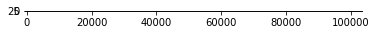

In [43]:
plt.imshow(asd)

In [54]:
#global scaling to have distribution -1/1
X_in = scaled_in(m_amp_db_audio)
#Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)

In [56]:
X_in.shape

(202, 128, 128, 1)

In [55]:
#Prediction using loaded network
X_pred = loaded_model.predict(X_in)

In [57]:
#Rescale back the noise model
inv_sca_X_pred = inv_scaled_ou(X_pred)

In [58]:
inv_sca_X_pred.shape

(202, 128, 128, 1)

In [59]:
#Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]

In [60]:
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)

In [61]:
audio_denoise_recons.flatten().shape

(1628928,)

In [62]:
from IPython.display import Audio
Audio(audio_denoise_recons.flatten(), rate=sample_rate)